In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, sqrtm
from scipy.integrate import solve_ivp

# ------------------------------
# Parameters
# ------------------------------
hbar = 1.0
Cm = 1.0             # membrane capacitance
g_leak = 0.1         # leak conductance
E_leak = -65.0       # leak reversal potential
alpha_g = 0.01       # gating rate
Vm0 = -65.0          # initial membrane potential
g0 = 0.5             # initial gating variable

# Quantum system
H0 = np.array([[0.0, 0.1], [0.1, 0.0]])   # base Hamiltonian
L = np.sqrt(0.05) * np.array([[0, 1], [0, 0]])   # Lindblad operator

# Simulation
dt = 0.1
T_total = 50
substeps = 5
alpha_feedback = 0.05

# ------------------------------
# Helper functions
# ------------------------------
def enforce_physical(rho):
    """Ensure rho is Hermitian, normalized, and positive."""
    rho = 0.5 * (rho + rho.conj().T)
    tr = np.trace(rho)
    if abs(tr) > 1e-14:
        rho /= tr
    return rho

def evolve_quantum(rho, H0, Vm, g, dtQ):
    """Unitary + Lindblad evolution with feedback coupling."""
    Vnl = np.array([[Vm/10.0, 0],[0, g]]) * alpha_feedback
    H = H0 + Vnl
    U = expm(-1j * H * dtQ / hbar)
    rho = U @ rho @ U.conj().T

    # Lindblad dissipator
    L_rho = L @ rho @ L.conj().T - 0.5 * (L.conj().T @ L @ rho + rho @ L.conj().T @ L)
    rho = rho + dtQ * L_rho
    return enforce_physical(rho)

def classical_rhs(t, y, rho):
    """Classical dynamics with quantum current coupling."""
    Vm, g = y
    I_leak = g_leak * (E_leak - Vm)
    IQ = np.real(np.trace(rho @ np.array([[1.0, 0],[0, -1.0]])))
    dVm = (I_leak + IQ) / Cm
    dg = -alpha_g * g
    return [dVm, dg]

def von_neumann_entropy(rho, eps=1e-12):
    vals = np.linalg.eigvalsh(rho)
    vals = np.clip(vals, eps, None)
    return -np.sum(vals * np.log(vals))

def trace_distance(rho1, rho2):
    return np.linalg.norm(rho1 - rho2, ord='fro')

def fidelity(rho1, rho2):
    sqrt_r1 = sqrtm(rho1)
    inter = sqrtm(sqrt_r1 @ rho2 @ sqrt_r1)
    return (np.real(np.trace(inter)))**2

# ------------------------------
# Simulation runner
# ------------------------------
def run_sim(use_ortt=True):
    rho = np.array([[1.0,0],[0,0]], dtype=complex)  # start in |0>
    Vm, g = Vm0, g0
    t = 0.0

    Vm_vals, g_vals, time_vals = [], [], []
    pop0_vals, pop1_vals, IQ_vals = [], [], []
    tauQ_vals, tauC_vals = [], []
    cum_tauQ, cum_tauC = 0.0, 0.0
    bloch_x, bloch_z = [], []
    rhos = []

    prev_S = von_neumann_entropy(rho)

    while t < T_total:
        # τ scaling (ORTT)
        if use_ortt:
            S = von_neumann_entropy(rho)
            dSdt = (S - prev_S) / dt if t > 1e-12 else 0.0
            prev_S = S
            tauQ_scale_val = 1.0 + 5.0 * np.tanh(dSdt)
            tauC_scale_val = 1.0 + 0.1*abs(Vm+65.0) + 0.2*g
        else:
            tauQ_scale_val, tauC_scale_val = 1.0, 1.0

        dtQ = dt * tauQ_scale_val / substeps
        dtC = dt * tauC_scale_val

        # Quantum substeps
        for _ in range(substeps):
            rho = evolve_quantum(rho, H0, Vm, g, dtQ)

        # Classical update
        sol = solve_ivp(classical_rhs, [0, dtC], [Vm, g], args=(rho,),
                        method='RK45', atol=1e-6, rtol=1e-6)
        Vm, g = sol.y[0,-1], sol.y[1,-1]

        # Store
        pop0, pop1 = np.real(rho[0,0]), np.real(rho[1,1])
        IQ = np.real(np.trace(rho @ np.array([[1.0,0],[0,-1.0]])))

        Vm_vals.append(Vm); g_vals.append(g); time_vals.append(t)
        pop0_vals.append(pop0); pop1_vals.append(pop1); IQ_vals.append(IQ)
        tauQ_vals.append(dtQ); tauC_vals.append(dtC)
        cum_tauQ += dtQ; cum_tauC += dtC
        bloch_x.append(2*np.real(rho[0,1])); bloch_z.append(pop0-pop1)
        rhos.append(rho.copy())

        t += dt

    return dict(
        Vm=Vm_vals, g=g_vals, t=time_vals,
        pop0=pop0_vals, pop1=pop1_vals, IQ=IQ_vals,
        tauQ=tauQ_vals, tauC=tauC_vals,
        cum_tauQ=np.cumsum(tauQ_vals), cum_tauC=np.cumsum(tauC_vals),
        bloch_x=bloch_x, bloch_z=bloch_z, rhos=rhos
    )

# ------------------------------
# Run control vs ORTT
# ------------------------------
ctrl = run_sim(use_ortt=False)
ortt = run_sim(use_ortt=True)

# ------------------------------
# Metrics
# ------------------------------
trace_dists = [trace_distance(r1, r2) for r1,r2 in zip(ortt['rhos'], ctrl['rhos'])]
fidelities = [fidelity(r1, r2) for r1,r2 in zip(ortt['rhos'], ctrl['rhos'])]
Vm_delta = np.array(ortt['Vm']) - np.array(ctrl['Vm'])

# Helper to save + show + print
def save_show(fig, filename):
    fig.tight_layout()
    fig.savefig(filename)
    print(f"[SAVED] {filename}")
    plt.show()





[SAVED] fig_delta_vm.pdf


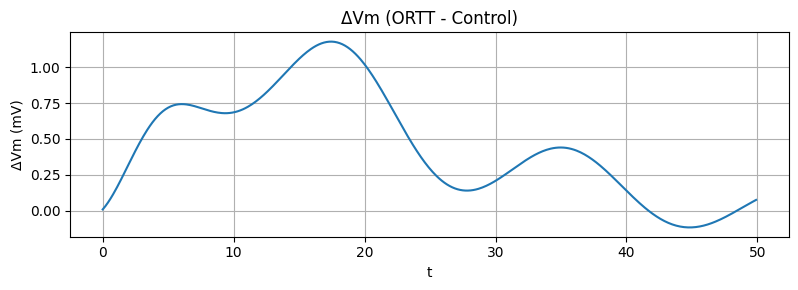

In [2]:
# ΔVm (ORTT - Control)
fig = plt.figure(figsize=(8,3))
plt.plot(ctrl['t'], Vm_delta)
plt.title("ΔVm (ORTT - Control)")
plt.xlabel("t"); plt.ylabel("ΔVm (mV)")
plt.grid(True)
save_show(fig, "fig_delta_vm.pdf")

[SAVED] fig_quantum_diff.pdf


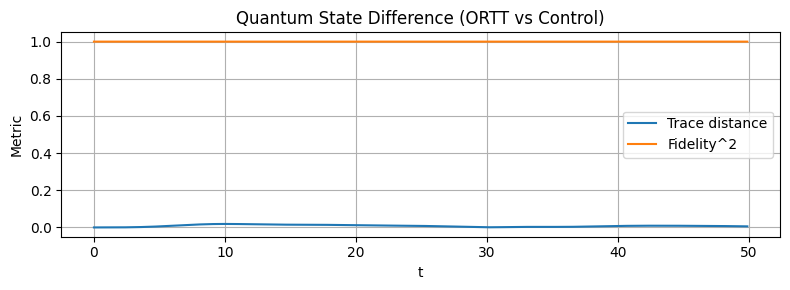

In [3]:
# Quantum state difference
fig = plt.figure(figsize=(8,3))
plt.plot(ctrl['t'], trace_dists, label="Trace distance")
plt.plot(ctrl['t'], fidelities, label="Fidelity^2")
plt.legend(); plt.xlabel("t"); plt.ylabel("Metric")
plt.title("Quantum State Difference (ORTT vs Control)")
plt.grid(True)
save_show(fig, "fig_quantum_diff.pdf")


[SAVED] fig_cumulative_tau.pdf


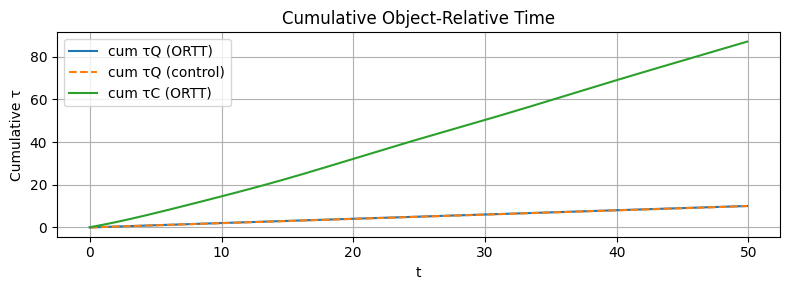

In [4]:
# Cumulative τ
fig = plt.figure(figsize=(8,3))
plt.plot(ctrl['t'], ortt['cum_tauQ'], label="cum τQ (ORTT)")
plt.plot(ctrl['t'], ctrl['cum_tauQ'], '--', label="cum τQ (control)")
plt.plot(ctrl['t'], ortt['cum_tauC'], label="cum τC (ORTT)")
plt.legend(); plt.xlabel("t"); plt.ylabel("Cumulative τ")
plt.title("Cumulative Object-Relative Time")
plt.grid(True)
save_show(fig, "fig_cumulative_tau.pdf")

[SAVED] fig_bloch_traj.pdf


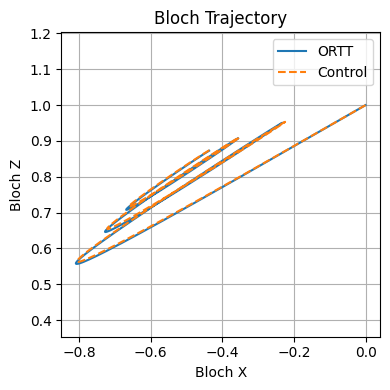

In [5]:
# Bloch trajectory
fig = plt.figure(figsize=(4,4))
plt.plot(ortt['bloch_x'], ortt['bloch_z'], label="ORTT")
plt.plot(ctrl['bloch_x'], ctrl['bloch_z'], '--', label="Control")
plt.xlabel("Bloch X"); plt.ylabel("Bloch Z")
plt.title("Bloch Trajectory")
plt.legend(); plt.grid(True); plt.axis('equal')
save_show(fig, "fig_bloch_traj.pdf")

[SAVED] fig_vm_pop.pdf


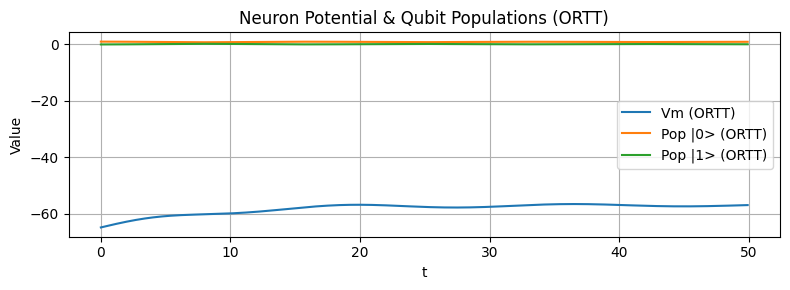

In [6]:
# Vm + populations
fig = plt.figure(figsize=(8,3))
plt.plot(ortt['t'], ortt['Vm'], label="Vm (ORTT)")
plt.plot(ortt['t'], ortt['pop0'], label="Pop |0> (ORTT)")
plt.plot(ortt['t'], ortt['pop1'], label="Pop |1> (ORTT)")
plt.legend(); plt.xlabel("t"); plt.ylabel("Value")
plt.title("Neuron Potential & Qubit Populations (ORTT)")
plt.grid(True)
save_show(fig, "fig_vm_pop.pdf")

[SAVED] fig_phase_traj.pdf


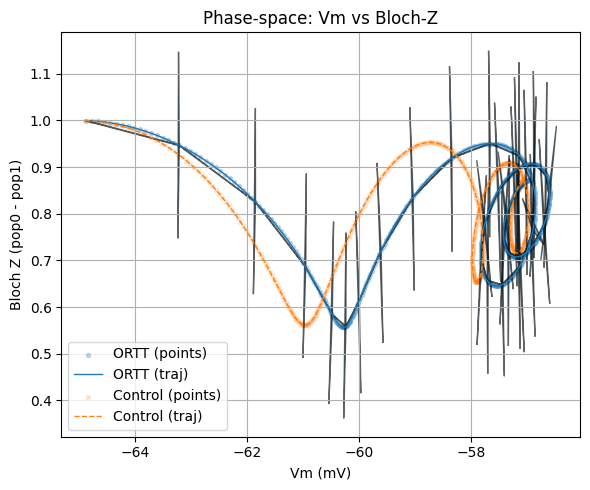

In [7]:
# Phase-space trajectory
Vm_ortt = np.array(ortt['Vm']); Z_ortt = np.array(ortt['bloch_z'])
Vm_ctrl = np.array(ctrl['Vm']); Z_ctrl = np.array(ctrl['bloch_z'])

fig = plt.figure(figsize=(6,5))
plt.scatter(Vm_ortt, Z_ortt, s=8, alpha=0.25, label="ORTT (points)")
plt.plot(Vm_ortt, Z_ortt, linewidth=1, label="ORTT (traj)")
plt.scatter(Vm_ctrl, Z_ctrl, s=8, alpha=0.25, marker='x', label="Control (points)")
plt.plot(Vm_ctrl, Z_ctrl, '--', linewidth=1, label="Control (traj)")
plt.xlabel("Vm (mV)"); plt.ylabel("Bloch Z (pop0 - pop1)")
plt.title("Phase-space: Vm vs Bloch-Z")
plt.legend(); plt.grid(True)

# arrows for trajectory
N = max(1, len(Vm_ortt)//30)
for i in range(0, len(Vm_ortt)-N, N):
    dx = Vm_ortt[i+N] - Vm_ortt[i]
    dz = Z_ortt[i+N] - Z_ortt[i]
    plt.arrow(Vm_ortt[i], Z_ortt[i], dx, dz,
              head_width=0.4, head_length=0.02,
              length_includes_head=True, alpha=0.6)
save_show(fig, "fig_phase_traj.pdf")

[SAVED] fig_phase_heatmap.pdf


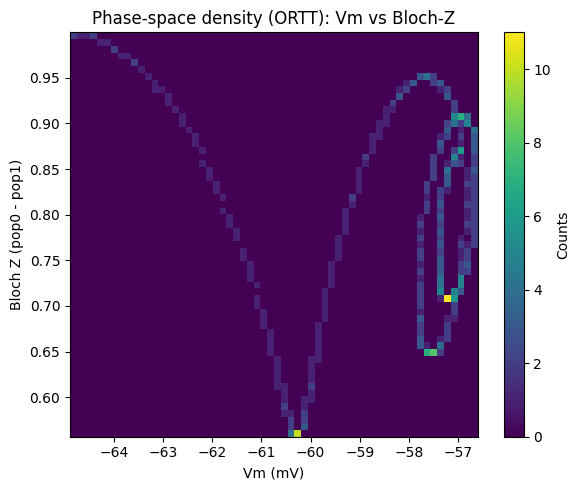

In [8]:
# Phase-space heatmap
fig = plt.figure(figsize=(6,5))
plt.hist2d(Vm_ortt, Z_ortt, bins=60)
plt.colorbar(label='Counts')
plt.xlabel("Vm (mV)"); plt.ylabel("Bloch Z (pop0 - pop1)")
plt.title("Phase-space density (ORTT): Vm vs Bloch-Z")
plt.grid(False)
save_show(fig, "fig_phase_heatmap.pdf")

[SAVED] ortt_dynamics.pdf


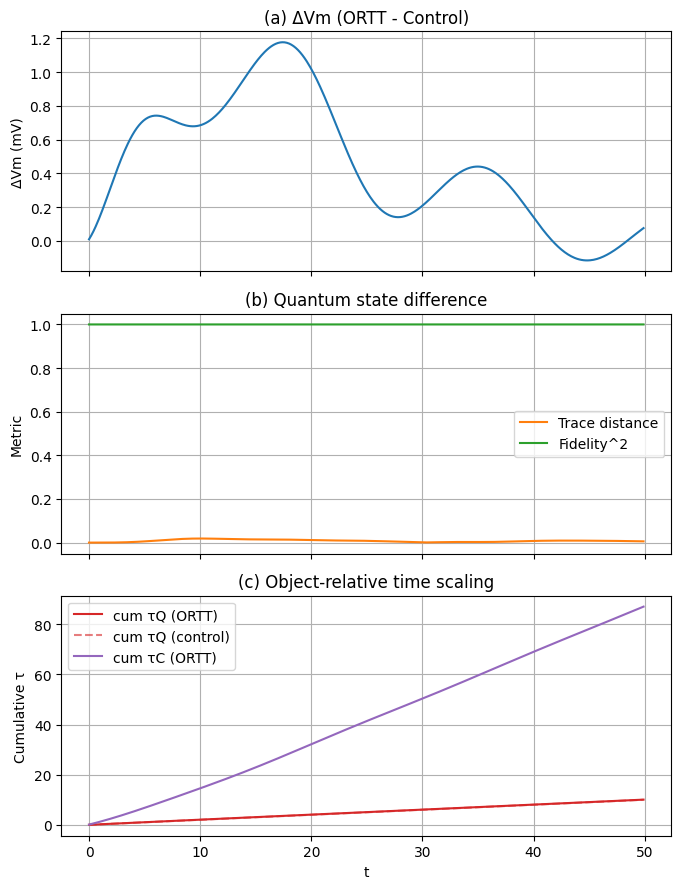

In [9]:
# ------------------------------
# Combined 3-panel ORTT dynamics figure
# ------------------------------
fig, axes = plt.subplots(3, 1, figsize=(7, 9), sharex=True)

# (a) ΔVm
axes[0].plot(ctrl['t'], Vm_delta, color='tab:blue')
axes[0].set_ylabel("ΔVm (mV)")
axes[0].set_title("(a) ΔVm (ORTT - Control)")
axes[0].grid(True)

# (b) Quantum metrics
axes[1].plot(ctrl['t'], trace_dists, label="Trace distance", color='tab:orange')
axes[1].plot(ctrl['t'], fidelities, label="Fidelity^2", color='tab:green')
axes[1].set_ylabel("Metric")
axes[1].set_title("(b) Quantum state difference")
axes[1].legend(); axes[1].grid(True)

# (c) Cumulative τ
axes[2].plot(ctrl['t'], ortt['cum_tauQ'], label="cum τQ (ORTT)", color='tab:red')
axes[2].plot(ctrl['t'], ctrl['cum_tauQ'], '--', label="cum τQ (control)", color='tab:red', alpha=0.6)
axes[2].plot(ctrl['t'], ortt['cum_tauC'], label="cum τC (ORTT)", color='tab:purple')
axes[2].set_xlabel("t")
axes[2].set_ylabel("Cumulative τ")
axes[2].set_title("(c) Object-relative time scaling")
axes[2].legend(); axes[2].grid(True)

fig.tight_layout()
fig.savefig("ortt_dynamics.pdf")
print("[SAVED] ortt_dynamics.pdf")
plt.show()